## Import Packages

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf
import itertools

## Pair Trading Modelling

In [70]:
class PairsTradeBacktest:
    def __init__(self, stock1, stock2, start_date, end_date, 
                 z_entry=2, z_exit=0.0, lookback=20,
                 commission_per_share=0.005,  # $0.005 per share
                 initial_capital=100000):     # Initial capital for position sizing
        self.stock1 = stock1
        self.stock2 = stock2
        self.start_date = start_date
        self.end_date = end_date
        self.z_entry = z_entry
        self.z_exit = z_exit
        self.lookback = lookback
        self.commission_per_share = commission_per_share
        self.initial_capital = initial_capital
        
    def get_data(self):
        data = yf.download([self.stock1, self.stock2], 
                          start=self.start_date, 
                          end=self.end_date)
        self.prices = data['Adj Close']
        self.volumes = data['Volume']
        return self.prices
    
    def calculate_hedge_ratio(self, data):
        model = OLS(data[self.stock1], data[self.stock2])
        results = model.fit()
        return results.params[0]
    
    def calculate_spread(self, data, hedge_ratio):
        spread = data[self.stock1] - hedge_ratio * data[self.stock2]
        return spread
    
    def calculate_zscore(self, spread):
        spread_mean = spread.rolling(window=self.lookback).mean()
        spread_std = spread.rolling(window=self.lookback).std()
        zscore = (spread - spread_mean) / spread_std
        return zscore
    
    def generate_signals(self, zscore):
        """Generate trading signals based on z-score thresholds with proper position management"""
        signals = pd.DataFrame(index=zscore.index)
        signals['positions'] = 0
        
        current_position = 0
        
        for i in range(len(zscore)):
            if current_position == 0:  # No position - look for entry signals
                if zscore[i] >= self.z_entry:
                    current_position = -1  # Enter short position
                elif zscore[i] <= -self.z_entry:
                    current_position = 1   # Enter long position
                    
            elif current_position == 1:  # In long position - look for exit signal
                if zscore[i] >= -self.z_exit:  # Exit long when spread narrows
                    current_position = 0
                    
            elif current_position == -1:  # In short position - look for exit signal
                if zscore[i] <= self.z_exit:   # Exit short when spread narrows
                    current_position = 0
                    
            signals.iloc[i] = current_position
        
        return signals
    
    def calculate_position_sizes(self, data, hedge_ratio):
        """Calculate number of shares for each stock based on capital allocation"""
        position_sizes = pd.DataFrame(index=data.index)
        
        # Allocate capital equally between the two stocks
        capital_per_stock = self.initial_capital / 2
        
        # Calculate number of shares for each stock
        stock1_shares = np.floor(capital_per_stock / data[self.stock1])
        stock2_shares = np.floor(hedge_ratio * capital_per_stock / data[self.stock2])
        
        position_sizes[self.stock1] = stock1_shares
        position_sizes[self.stock2] = stock2_shares
        
        return position_sizes
    
    def calculate_commission_costs(self, positions, position_sizes):
        """Calculate commission costs based on number of shares traded"""
        # Detect position changes
        position_changes = positions.diff().fillna(0)
        
        # Calculate commission costs for both legs of the trade
        costs = pd.Series(0.0, index=positions.index)
        
        for i in range(len(costs)):
            if position_changes.iloc[i] != 0:
                # Get number of shares for each stock at this point
                stock1_shares = position_sizes[self.stock1].iloc[i]
                stock2_shares = position_sizes[self.stock2].iloc[i]
                
                # Calculate total commission (entry or exit for both legs)
                total_shares = stock1_shares + stock2_shares
                commission = total_shares * self.commission_per_share
                
                costs.iloc[i] = commission
        
        return costs
    
    def calculate_returns(self, data, signals, hedge_ratio):
        # Calculate position sizes
        position_sizes = self.calculate_position_sizes(data, hedge_ratio)
        
        # Calculate raw returns
        stock1_returns = data[self.stock1].pct_change()
        stock2_returns = data[self.stock2].pct_change()
        
        # Shift positions to avoid look-ahead bias
        positions = signals['positions'].shift(1)
        
        # Calculate raw strategy returns
        strategy_returns = positions * (stock1_returns - hedge_ratio * stock2_returns)
        
        # Calculate commission costs
        commission_costs = self.calculate_commission_costs(positions, position_sizes)
        
        # Convert commission costs to returns
        portfolio_value = (1 + strategy_returns).cumprod() * self.initial_capital
        cost_returns = -commission_costs / portfolio_value
        
        # Combine raw returns and commission costs
        net_returns = strategy_returns + cost_returns
        
        return {
            'net_returns': net_returns,
            'raw_returns': strategy_returns,
            'commission_costs': commission_costs,
            'cost_returns': cost_returns,
            'position_sizes': position_sizes
        }
    
    def calculate_metrics(self, returns_data):
        returns = returns_data['net_returns']
        total_costs = returns_data['commission_costs'].sum()
        
        metrics = {}
        metrics['Total Return'] = (1 + returns).prod() - 1
        metrics['Annual Return'] = (1 + returns).prod() ** (252/len(returns)) - 1
        metrics['Sharpe Ratio'] = np.sqrt(252) * returns.mean() / returns.std()
        metrics['Max Drawdown'] = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()) - 1
        metrics['Max Drawdown'] = metrics['Max Drawdown'].min()
        metrics['Total Commission Costs'] = total_costs
        metrics['Commission Costs %'] = total_costs / self.initial_capital
        metrics['Number of Trades'] = (returns_data['commission_costs'] > 0).sum()
        
        # Add average shares traded per trade
        avg_shares = (returns_data['position_sizes'][self.stock1].mean() + 
                     returns_data['position_sizes'][self.stock2].mean())
        metrics['Average Shares per Trade'] = avg_shares
        
        return metrics
  
    def plot_results(self, results):
        """Enhanced plotting function with correct entry/exit points"""
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 20))
        
        # Plot prices
        ax1.plot(results['data'][self.stock1], label=self.stock1)
        ax1.plot(results['data'][self.stock2], label=self.stock2)
        ax1.set_title('Stock Prices')
        ax1.legend()
        ax1.grid(True)
        
        # Plot spread and z-score with trade signals
        ax2.plot(results['zscore'], label='Z-Score', color='blue', alpha=0.7)
        ax2.axhline(y=self.z_entry, color='r', linestyle='--', label='Entry Threshold (+)')
        ax2.axhline(y=-self.z_entry, color='r', linestyle='--', label='Entry Threshold (-)')
        ax2.axhline(y=self.z_exit, color='g', linestyle='--', label='Exit Threshold')
        ax2.axhline(y=-self.z_exit, color='g', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        
        # Get positions and position changes
        positions = results['signals']['positions']
        position_changes = positions.diff()
        
        # Correctly identify entry and exit points
        entries_long = []
        entries_short = []
        exits = []
        
        prev_pos = 0
        for i in range(len(positions)):
            curr_pos = positions.iloc[i]
            if curr_pos != prev_pos:  # Position change detected
                if prev_pos == 0:  # Was flat, now entering
                    if curr_pos == 1:
                        entries_long.append(positions.index[i])
                    else:
                        entries_short.append(positions.index[i])
                else:  # Was in position, now exiting
                    exits.append(positions.index[i])
                prev_pos = curr_pos
    
        # Convert to index objects for plotting
        entries_long = pd.Index(entries_long)
        entries_short = pd.Index(entries_short)
        exits = pd.Index(exits)
        
        # Shade background based on positions
        last_entry = None
        last_pos = 0
        for i in range(len(positions)):
            curr_pos = positions.iloc[i]
            if curr_pos != last_pos:  # Position change
                if last_entry is None and curr_pos != 0:  # New entry
                    last_entry = positions.index[i]
                elif last_entry is not None and curr_pos == 0:  # Exit
                    if positions.iloc[i-1] == 1:  # Was long position
                        ax2.axvspan(last_entry, positions.index[i], alpha=0.2, color='green', 
                                label='Long Position' if last_pos == 0 else "")
                    else:  # Was short position
                        ax2.axvspan(last_entry, positions.index[i], alpha=0.2, color='red', 
                                label='Short Position' if last_pos == 0 else "")
                    last_entry = None
                last_pos = curr_pos
        
        # Plot entry/exit points on z-score
        if len(entries_long) > 0:
            ax2.scatter(entries_long, results['zscore'][entries_long], color='g', marker='^', 
                    s=100, label='Long Entry', zorder=5)
        if len(entries_short) > 0:
            ax2.scatter(entries_short, results['zscore'][entries_short], color='r', marker='v', 
                    s=100, label='Short Entry', zorder=5)
        if len(exits) > 0:
            ax2.scatter(exits, results['zscore'][exits], color='k', marker='x', 
                    s=100, label='Exit', zorder=5)
        
        ax2.set_title('Z-Score of Spread with Trade Signals')
        ax2.legend()
        ax2.grid(True)
    
        # Plot cumulative returns with trade points
        raw_returns = (1 + results['returns_data']['raw_returns']).cumprod() - 1
        net_returns = (1 + results['returns_data']['net_returns']).cumprod() - 1
        
        ax3.plot(raw_returns, label='Raw Returns', color='blue', alpha=0.7)
        ax3.plot(net_returns, label='Net Returns (after commission)', color='green', alpha=0.7)
        
        # Shade background on returns plot using same logic
        last_entry = None
        last_pos = 0
        for i in range(len(positions)):
            curr_pos = positions.iloc[i]
            if curr_pos != last_pos:
                if last_entry is None and curr_pos != 0:
                    last_entry = positions.index[i]
                elif last_entry is not None and curr_pos == 0:
                    if positions.iloc[i-1] == 1:
                        ax3.axvspan(last_entry, positions.index[i], alpha=0.2, color='green')
                    else:
                        ax3.axvspan(last_entry, positions.index[i], alpha=0.2, color='red')
                    last_entry = None
                last_pos = curr_pos
        
        # Plot entry/exit points on returns
        if len(entries_long) > 0:
            ax3.scatter(entries_long, raw_returns[entries_long], color='g', marker='^', 
                    s=100, label='Long Entry', zorder=5)
        if len(entries_short) > 0:
            ax3.scatter(entries_short, raw_returns[entries_short], color='r', marker='v', 
                    s=100, label='Short Entry', zorder=5)
        if len(exits) > 0:
            ax3.scatter(exits, raw_returns[exits], color='k', marker='x', 
                    s=100, label='Exit', zorder=5)
        
        ax3.set_title('Cumulative Returns')
        ax3.legend()
        ax3.grid(True)
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        # Plot cumulative commission costs
        cumulative_costs = results['returns_data']['commission_costs'].cumsum()
        ax4.plot(cumulative_costs)
        if len(exits) > 0:
            ax4.scatter(exits, cumulative_costs[exits], color='k', marker='x', 
                    s=100, label='Trade Exit Points', zorder=5)
        ax4.set_title('Cumulative Commission Costs ($)')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def run_backtest(self):
        """Run the complete backtest and return all results"""
        # Get price data
        data = self.get_data()
        
        # Calculate hedge ratio
        hedge_ratio = self.calculate_hedge_ratio(data)
        
        # Calculate spread
        spread = self.calculate_spread(data, hedge_ratio)
        
        # Calculate z-score
        zscore = self.calculate_zscore(spread)
        
        # Generate trading signals
        signals = self.generate_signals(zscore)
        
        # Calculate returns and costs
        returns_data = self.calculate_returns(data, signals, hedge_ratio)
        
        # Calculate performance metrics
        metrics = self.calculate_metrics(returns_data)
        
        return {
            'data': data,
            'hedge_ratio': hedge_ratio,
            'spread': spread,
            'zscore': zscore,
            'signals': signals,
            'returns_data': returns_data,
            'metrics': metrics
        }


## Optimization Modelling

In [ ]:
Opt_backtest = PairsTradeBacktest(
        stock1='KO',
        stock2='YUM',
        start_date='2020-01-01',
        end_date='2020-12-31',
        z_entry=2,
        z_exit=0.0,
        lookback=20,
        commission_per_share=0.005,  # $0.005 per share
        initial_capital=100000
    )
    
Opt_results = backtest.run_backtest()

#### Remove futurewaring messege

In [77]:
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Your code that triggers the FutureWarning goes here

## Optimization in z_entry, z_exit, lookback
### z_entry threshold range  1.0 - 2.0, shifting by 0.1
### z_exit threshold range  0.0 - 1.0, shifting by 0.1
### lookback range 20 - 30, shifting by 1
#### Traning and Test Set Ratio = 80 : 20, which is equivalent to 4 years (2019-2022) to 1 year(2023)

In [ ]:
Opt_entry = np.arange(1,2.1,0.1)
Opt_exit = np.arange(0,1.1,0.1)
Opt_lookback = np.arange(20,31,1)
value_shift = 0
Max_SP = dict()
for i in Opt_entry:
    for j in Opt_exit:
        for k in Opt_lookback:
            Opt_backtest = PairsTradeBacktest(
            stock1='KO',
            stock2='YUM',
            start_date='2019-01-01',
            end_date='2022-12-31',
            z_entry=i,
            z_exit=j,
            lookback=k,
            commission_per_share=0.005,  # $0.005 per share
            initial_capital=100000
            )
            
            Opt_results = Opt_backtest.run_backtest()
            
            if Opt_results['metrics']['Sharpe Ratio'] > value_shift:
                Max_SP = dict()
                Max_SP[Opt_results['metrics']['Sharpe Ratio']] = (i,j,k)
                value_shift = Opt_results['metrics']['Sharpe Ratio']

            print((i,j,k),Opt_results['metrics']['Sharpe Ratio'])    

In [97]:
for i, j in Max_SP.items():
    print("Annualized Sharpe Ratio", i)
    print("Optimal z_entry", j[0])
    print("Optimal z_exit", j[1])
    print("Optimal lookback", j[2])


Annualized Sharpe Ratio 3.395197610304108
Optimal z_entry 1.6000000000000005
Optimal z_exit 0.2
Optimal lookback 20


[*********************100%%**********************]  2 of 2 completed



Performance Metrics:
Total Return: 5.34%
Annual Return: 5.38%
Sharpe Ratio: 69.55%
Max Drawdown: -4.45%
Total Commission Costs: $120.73
Commission Costs %: 0.12%
Number of Trades: 23
Average Shares per Trade: 1,048


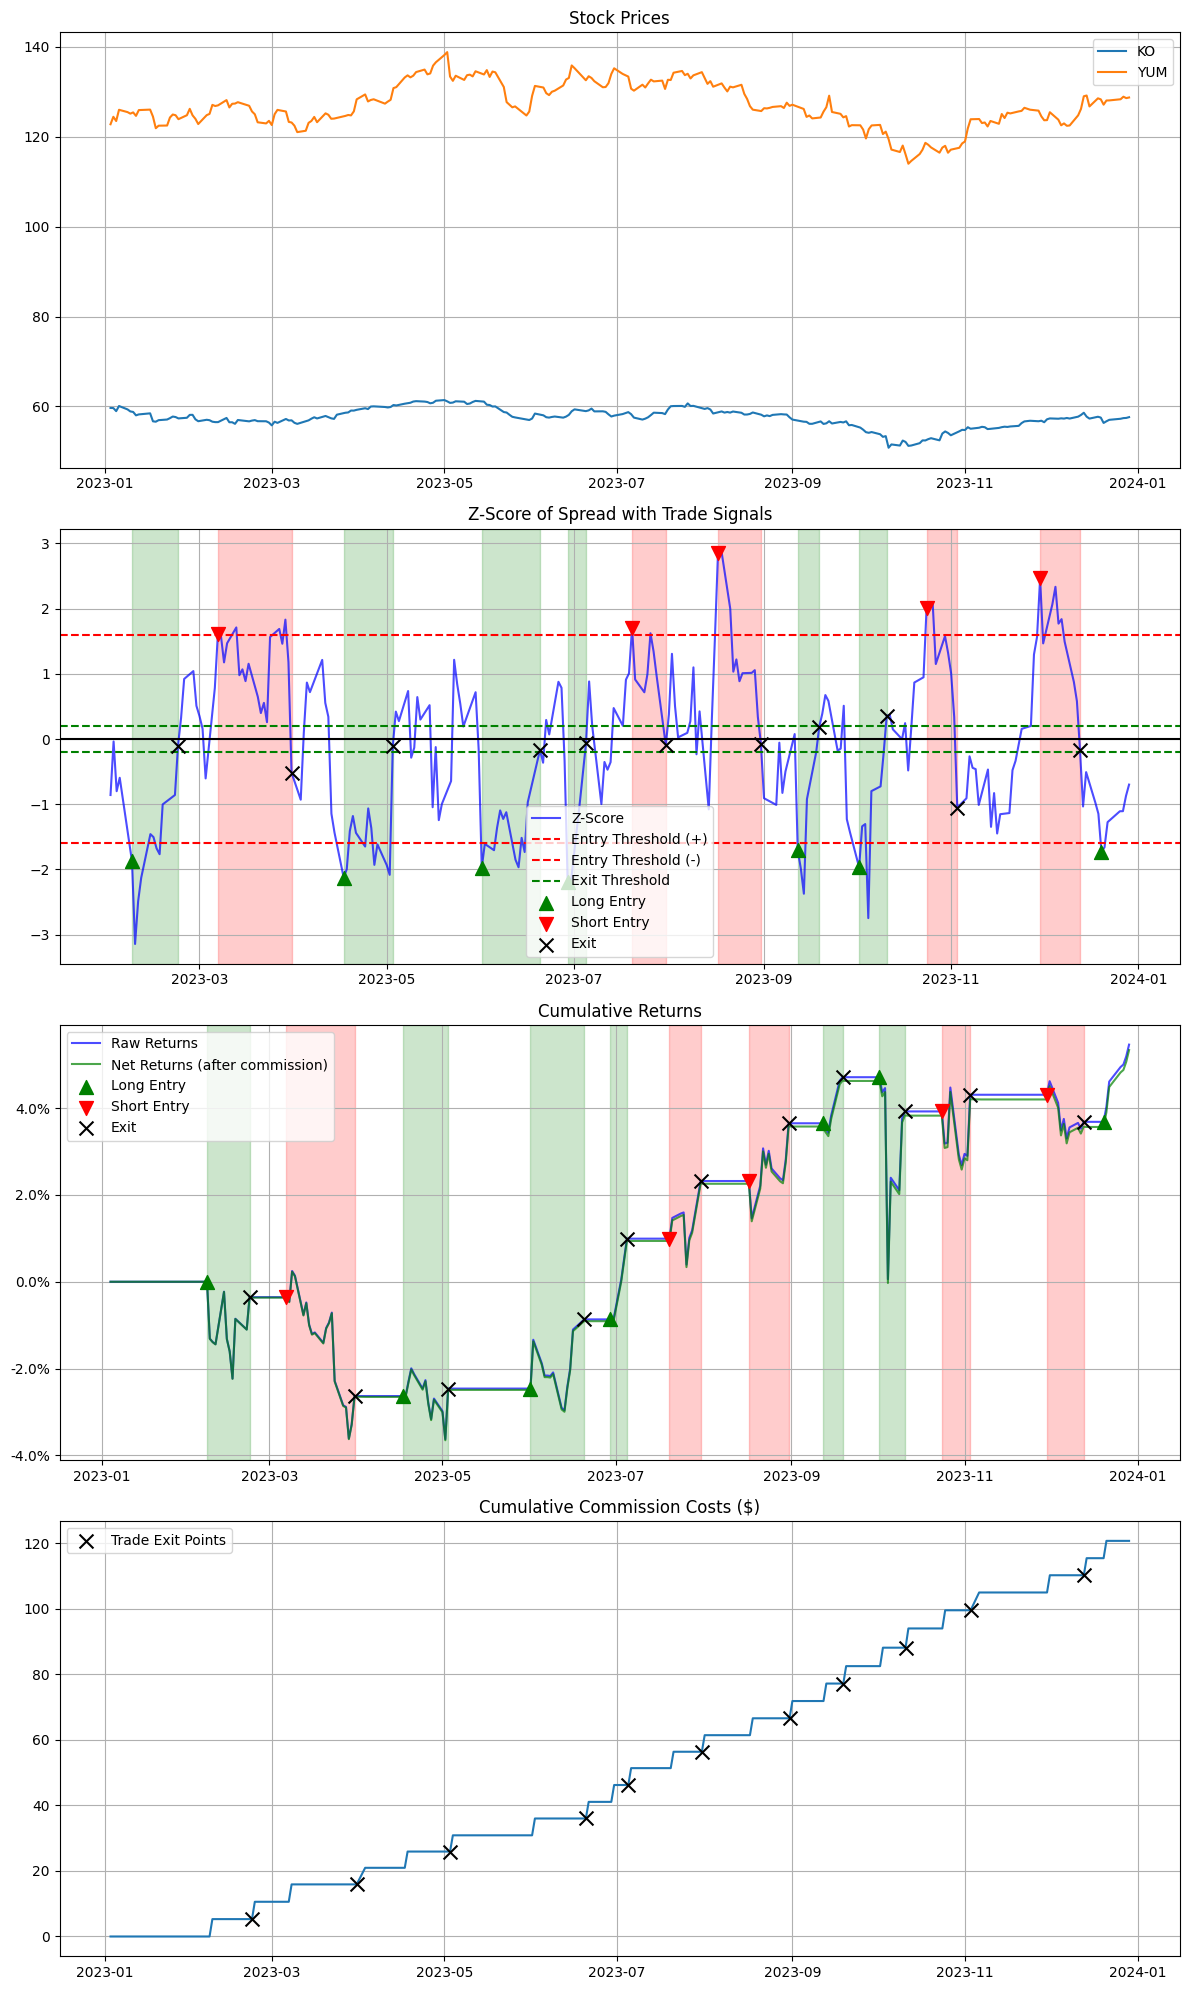

In [98]:
if __name__ == "__main__":
    # Initialize with per-share commission
    backtest = PairsTradeBacktest(
        stock1='KO',
        stock2='YUM',
        start_date='2023-01-01',
        end_date='2023-12-31',
        z_entry=1.6,
        z_exit=0.2,
        lookback=20,
        commission_per_share=0.005,  # $0.005 per share
        initial_capital=100000
    )
    
    results = backtest.run_backtest()
    
    # Print metrics
    print("\nPerformance Metrics:")
    for metric, value in results['metrics'].items():
        if metric == 'Total Commission Costs':
            print(f"{metric}: ${value:,.2f}")
        elif metric == 'Number of Trades':
            print(f"{metric}: {int(value)}")
        elif metric == 'Average Shares per Trade':
            print(f"{metric}: {int(value):,}")
        elif 'Costs %' in metric:
            print(f"{metric}: {value:.2%}")
        else:
            print(f"{metric}: {value:.2%}")
    
    # Plot results
    backtest.plot_results(results)